In [2]:
import os

import pandas as pd 
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras import layers
import numpy as np
import datetime as dt
import imageio
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json

from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from tqdm import tqdm


In [3]:
emotions = ["Aversion", "Anger", "Happiness", "Fear", "Sadness", "Surprise", "Peace"]

train_data = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=0.1,
    zoom_range=0.1,
    validation_split=0.2
)

validation_data = ImageDataGenerator(rescale=1./255)

train_images = train_data.flow_from_directory(
    r"E:\train_gen_joints",
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_data.flow_from_directory(
    r"E:\train_gen_joints",
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

print("Shape of train images:", train_images.image_shape)
print("Shape of train labels:", train_images.classes.shape)


Found 316912 images belonging to 7 classes.
Found 79225 images belonging to 7 classes.
Shape of train images: (64, 64, 3)
Shape of train labels: (316912,)


In [4]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(len(emotions), activation='softmax'))

# Compile the model
emotion_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath='eMotion2_checkpoint.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = emotion_model.fit(
    train_images,
    steps_per_epoch=9904,  # Cover all training data
    epochs=20,
    validation_data=val_images,
    validation_steps=2476,  # Cover all validation data
    callbacks=[early_stopping]
)

# Check if the model has weights before saving
print(emotion_model.get_weights())

# Save the model architecture
model_json = emotion_model.to_json()
with open("eMotionModel2.json", "w") as json_file:
    json_file.write(model_json)

# Save trained model weights
emotion_model.save('eMotion2.h5')




Epoch 1/20


9904/9904 [==============================] - 11187s 1s/step - loss: 1.6194 - accuracy: 0.3644 - val_loss: 1.3070 - val_accuracy: 0.5203
Epoch 2/20
9904/9904 [==============================] - 10393s 1s/step - loss: 1.1970 - accuracy: 0.5532 - val_loss: 1.0770 - val_accuracy: 0.6052
Epoch 3/20
9904/9904 [==============================] - 9986s 1s/step - loss: 1.0201 - accuracy: 0.6187 - val_loss: 0.9530 - val_accuracy: 0.6429
Epoch 4/20
9904/9904 [==============================] - 10109s 1s/step - loss: 0.9244 - accuracy: 0.6508 - val_loss: 0.9160 - val_accuracy: 0.6551
Epoch 5/20
9904/9904 [==============================] - 9131s 922ms/step - loss: 0.8606 - accuracy: 0.6710 - val_loss: 0.8786 - val_accuracy: 0.6696
Epoch 6/20
9904/9904 [==============================] - 8522s 860ms/step - loss: 0.8144 - accuracy: 0.6854 - val_loss: 0.8485 - val_accuracy: 0.6773
Epoch 7/20
9904/9904 [==============================] - 8517s 860ms/step - loss: 0.7758 - accuracy: 0.6985 - v

d:\Python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model

def check_h5_file(file_path):
    try:
        # Attempt to load the model
        model = load_model(file_path)
        
        # Check if the model has weights
        if len(model.get_weights()) == 0:
            print("The model is loaded but has no weights. The file might be empty or corrupt.")
            return False
        
        print("The model is loaded and contains weights.")
        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

# Path to your .h5 file
file_path = r"D:\THESIS 2.0\eMotion2.h5"
is_valid = check_h5_file(file_path)

if is_valid:
    print("The .h5 file is valid and not empty.")
else:
    print("The .h5 file is either empty or corrupt.")


The model is loaded and contains weights.
The .h5 file is valid and not empty.


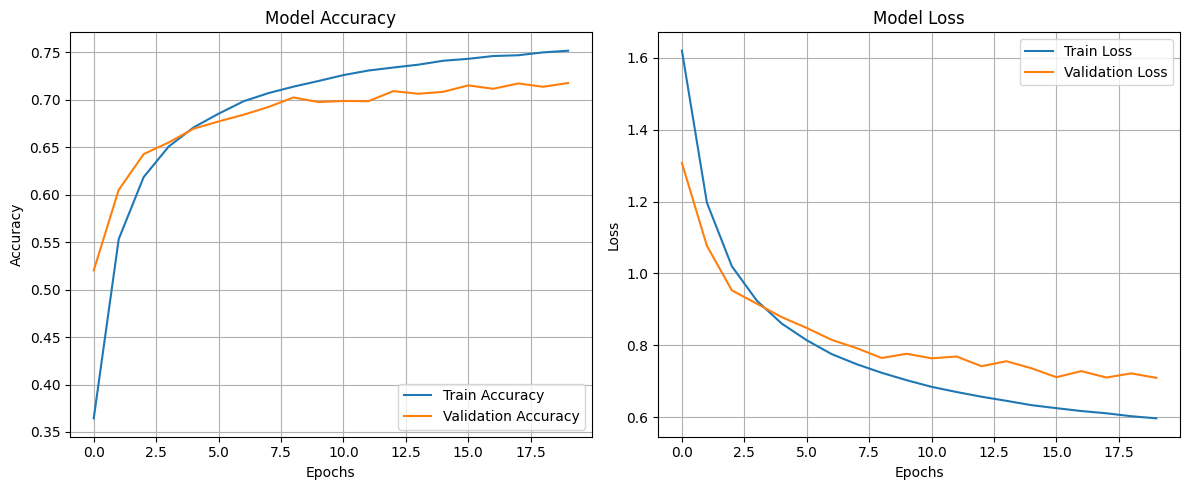

In [6]:
plt.figure(figsize=(12, 5))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


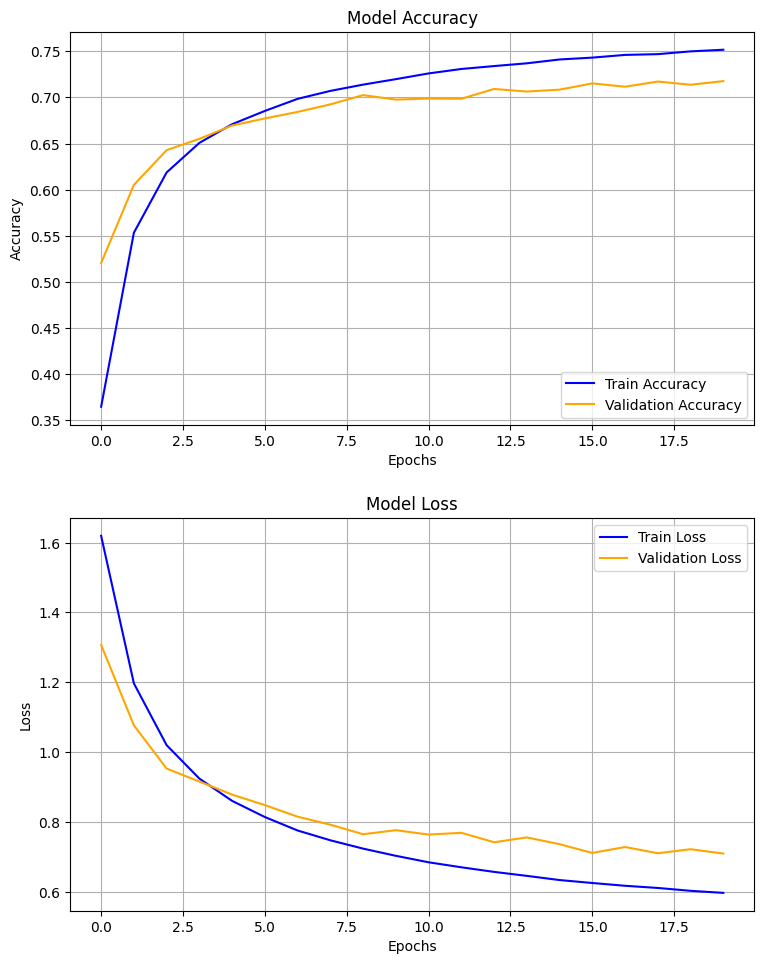

In [7]:
plt.figure(figsize=(8, 10))

# Accuracy Plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout(pad=2.0)  # Adjust padding for tighter layout

# Loss Plot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout(pad=2.0)  # Adjust padding for tighter layout

# Show the plots
plt.show()
